In [0]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torchvision.datasets as dast
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
batch_size=128
dataset=dast.ImageFolder(root='/content/drive/My Drive/gan_data',transform=transforms.Compose([transforms.Resize(64),
                                                                                               transforms.CenterCrop(64),
                                                                                                  transforms.ToTensor(),
                                                                                                  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))

dataloader=torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

In [0]:
def weights_init(d):
  classname=d.__class__.__name__
  if classname.find('Conv')!=-1:
    nn.init.normal_(d.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm')!=-1:
    nn.init.normal_(d.weight.data, 1.0, 0.02)
    nn.init.constant_(d.bias.data,0)

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.main=nn.Sequential(
        nn.ConvTranspose2d(100,64*8,4,1,0,bias=False),
        nn.BatchNorm2d(64*8),
        nn.ReLU(True),
        nn.ConvTranspose2d(64*8,32*8,4,2,1,bias=False),
        nn.BatchNorm2d(32*8),
        nn.ReLU(True),
        nn.ConvTranspose2d(32*8,16*8,4,2,1,bias=False),
        nn.BatchNorm2d(16*8),
        nn.ReLU(True),
        nn.ConvTranspose2d(16*8,8*8,4,2,1,bias=False),
        nn.BatchNorm2d(8*8),
        nn.ReLU(True),
        nn.ConvTranspose2d(8*8,3,4,2,1,bias=False),
        nn.Tanh()
    )
  def forward(self,input):
    return self.main(input)


In [0]:
G=Generator()

In [7]:
G.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.main=nn.Sequential(
        nn.Conv2d(3,64,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(64,128,4,2,1,bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(128,256,4,2,1,bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(256,512,4,2,1,bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(512,1,4,2,0,bias=False),
        nn.Sigmoid()
    )
  def forward(self,inp):
    return self.main(inp)

In [0]:
D=Discriminator()

In [10]:
D.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)

In [0]:
criterion=nn.BCELoss()

In [0]:
optimizerD=torch.optim.Adam(D.parameters(),0.0002,betas=(0.5,0.999))
optimizerG=torch.optim.Adam(G.parameters(),0.0002,betas=(0.5,0.999))

In [0]:
rl=1
fl=0
epochs=10
images=[]
fnoise=torch.randn(16,100,1,1)

In [14]:
for epoch in range(epochs):
  for i,data in enumerate(dataloader,0):
    D.zero_grad()
    imgd=data[0]
    b_size=imgd.size(0)
    label=torch.full((b_size,),rl)
    output=D(imgd).view(-1)
    dloss_r=criterion(output,label)
    dloss_r.backward()
    noise=torch.randn(b_size,100,1,1)
    fake=G(noise)
    label.fill_(fl)
    output=D(fake.detach()).view(-1)
    dgf=output.mean().item()
    dloss_f=criterion(output,label)
    dloss_f.backward()
    dloss=dloss_f+dloss_r
    optimizerD.step()

    #generator turn
    G.zero_grad()
    label.fill_(rl)
    output=D(fake).view(-1)
    dgr=output.mean().item()
    gloss=criterion(output,label)
    gloss.backward()
    optimizerG.step()
    if i%50==0:
      print('epoch_no',epoch,'iteration_no',i,'dloss',dloss.item(),'gloss',gloss.item(),'DGZR',dgr,'DGZF',dgf)
    if i==len(dataloader)-1:
      with torch.no_grad():
            fake = G(fnoise).detach().cpu()
            images.append(vutils.make_grid(fake, padding=2, normalize=True))

epoch_no 0 iteration_no 0 dloss 2.1347475051879883 gloss 3.8218772411346436 DGZR 0.03480272740125656 DGZF 0.6172488927841187
epoch_no 0 iteration_no 50 dloss 0.03803998604416847 gloss 10.974888801574707 DGZR 3.644163371063769e-05 DGZF 0.00015141337644308805
epoch_no 1 iteration_no 0 dloss 0.24728575348854065 gloss 21.965425491333008 DGZR 1.3481185057173661e-09 DGZF 1.7615512382107568e-09
epoch_no 1 iteration_no 50 dloss 1.4740955829620361 gloss 25.602663040161133 DGZR 1.1980406250389208e-11 DGZF 0.7333176732063293
epoch_no 2 iteration_no 0 dloss 0.044191427528858185 gloss 7.898348331451416 DGZR 0.0008272207342088223 DGZF 0.011341897770762444
epoch_no 2 iteration_no 50 dloss 0.23981043696403503 gloss 5.916141986846924 DGZR 0.0040001291781663895 DGZF 0.17708471417427063
epoch_no 3 iteration_no 0 dloss 0.2111300379037857 gloss 8.026129722595215 DGZR 0.0004790793755091727 DGZF 0.17711664736270905
epoch_no 3 iteration_no 50 dloss 0.049634069204330444 gloss 6.176836013793945 DGZR 0.004025447

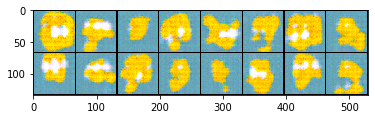

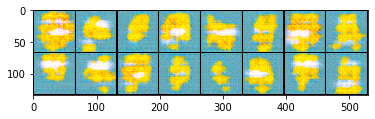

In [16]:
plt.imshow(np.transpose(images[-1],(1,2,0)))

torch.Size([3, 134, 530])